# TRAUMATIC INJURY

# Read data from database and build a line chart

In [1]:
import sys
!{sys.executable} -m pip install --user statsmodels

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb
import pandas as pd
import itertools
import statsmodels.api as sm
from datetime import datetime
from calendar import monthrange
import math
import warnings
warnings.filterwarnings("ignore")

def getData(county):
    county = county
    conn = MySQLdb.connect(host="localhost", user="i501fa18_group7", passwd="rEm9z3dRGW11", db="i501fa18_group7")
    cursor = conn.cursor()
    if(county == 'all'):
        condition = 'SIT_PROVIDER_PRIM_IMPRESSION = \'Traumatic Injury\''
    else:
        condition = 'inc_county = \'%s\' and SIT_PROVIDER_PRIM_IMPRESSION = \'Traumatic Injury\' ' % (county)

    str1="select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_trauma_calls from i501fa18_group7.emergency_medical_service_runs_2014 WHERE %s group by LAST_DAY(INC_INCIDENTDATE)"
    str2="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_trauma_calls from i501fa18_group7.emergency_medical_service_runs_2015 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str3="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_trauma_calls from i501fa18_group7.emergency_medical_service_runs_2016 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str4="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH, count(INC_INCIDENTID) as Numn_of_trauma_calls from i501fa18_group7.emergency_medical_service_runs_2017 Where %s and LAST_DAY(INC_INCIDENTDATE) < \'2017-08-31\' group by LAST_DAY(INC_INCIDENTDATE)"


    query = str1%(condition) + str2%(condition)+ str3%(condition)+ str4%(condition)
    cursor.execute(query);
    rows = cursor.fetchall() 
    months = []
    traumatic_injury_calls = []

    for i in rows:
        months.append(datetime.combine(i[0],datetime.min.time()))
        traumatic_injury_calls.append(i[1])

    my_data = pd.DataFrame(
        {'Months': months,
         'Traumatic_Injury_Calls': traumatic_injury_calls
         })
    my_data = my_data.set_index('Months')
    return my_data;

def decomposeData(my_data):
    check_seasonal = sm.tsa.seasonal_decompose(my_data, model='multiplicative')
    fig = check_seasonal.plot()
    plt.title('Seasonal trending of the Traumatic Injury Calls Data')
    plt.show()
    
trauma_injury_calls = getData('all');
print("Properties of the data are :" , trauma_injury_calls.describe())
trauma_injury_calls.plot(figsize=(15,6))
plt.title('Traumatic Injury Calls by Month')
plt.show()

Properties of the data are :        Traumatic_Injury_Calls
count               43.000000
mean              6480.581395
std               1271.168983
min               3534.000000
25%               5779.000000
50%               6532.000000
75%               7611.000000
max               8553.000000


<Figure size 1500x600 with 1 Axes>

#  Seasonal decompose of the data

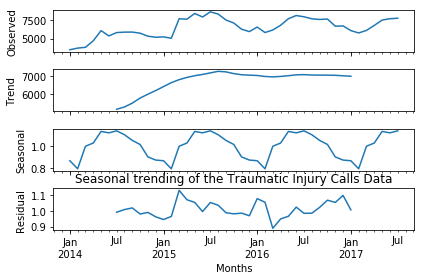

In [3]:
decomposeData(trauma_injury_calls)


# Train the ARIMAX model for data from 2014 to 2016

In [4]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

min_aic = 1000
min_param = ()
min_param_seasonal = ()

train_data = trauma_injury_calls[:2016]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            train_mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = train_mod.fit()
            if (results.aic <= min_aic):
                min_aic = results.aic
                min_param = param
                min_param_seasonal = param_seasonal
            
        except:
            continue

print('minimum AIC in observed at ', min_param, min_param_seasonal, min_aic)          

minimum AIC in observed at  (1, 1, 0) (1, 1, 0, 12) 268.367058598085


# Build ARIMAX model using the parameters for minimum AIC

In [5]:
mod = sm.tsa.statespace.SARIMAX(trauma_injury_calls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

for i in range(3):
    print(results.summary().tables[i])

                                 Statespace Model Results                                 
Dep. Variable:             Traumatic_Injury_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -131.184
Date:                            Sat, 15 Dec 2018   AIC                            268.367
Time:                                    20:04:33   BIC                            270.867
Sample:                                01-31-2014   HQIC                           268.616
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2697      0.360     -0.749      0.454      -0.976       0.436
ar.S.L12      -0.5403      0.096   

# Check diagnostics to make sure the model doesn't produce incorrect results

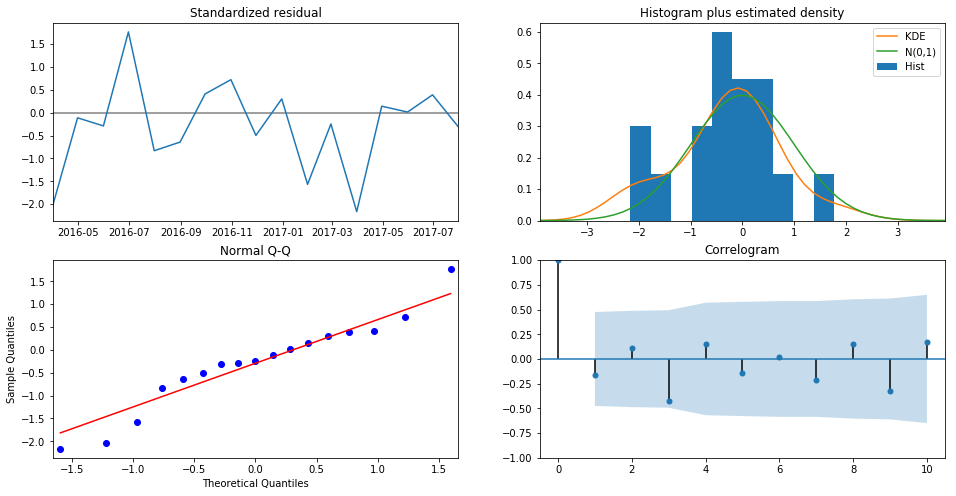

In [6]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

# Predicting the values for 2017 based on training data

                                 Statespace Model Results                                 
Dep. Variable:             Traumatic_Injury_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -131.184
Date:                            Sat, 15 Dec 2018   AIC                            268.367
Time:                                    20:04:36   BIC                            270.867
Sample:                                01-31-2014   HQIC                           268.616
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2697      0.360     -0.749      0.454      -0.976       0.436
ar.S.L12      -0.5403      0.096   

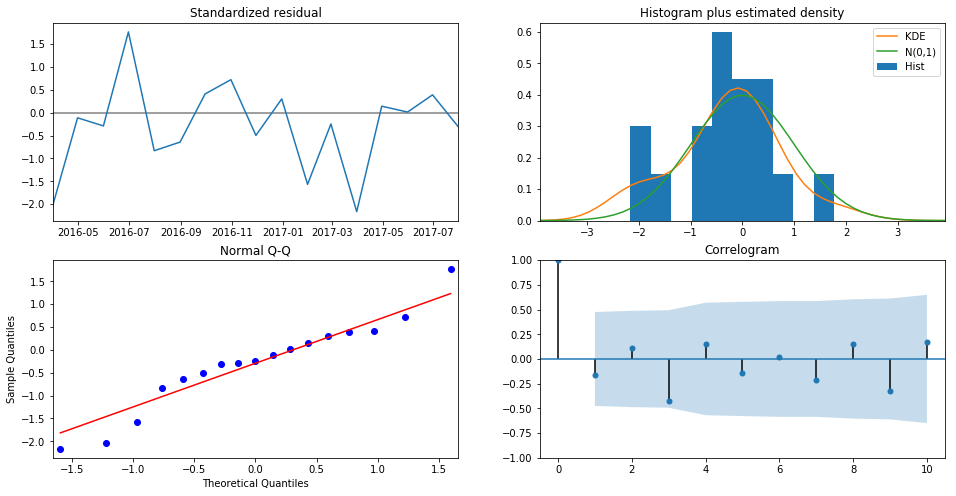

            lower Traumatic_Injury_Calls  upper Traumatic_Injury_Calls
2017-01-31                   5852.812086                   7982.671102
2017-02-28                   4821.121319                   6950.980335
2017-03-31                   6202.992869                   8332.851885
2017-04-30                   5610.713549                   7740.572565
2017-05-31                   6386.431646                   8516.290662
2017-06-30                   6361.902913                   8491.761929
2017-07-31                   6804.080254                   8933.939270


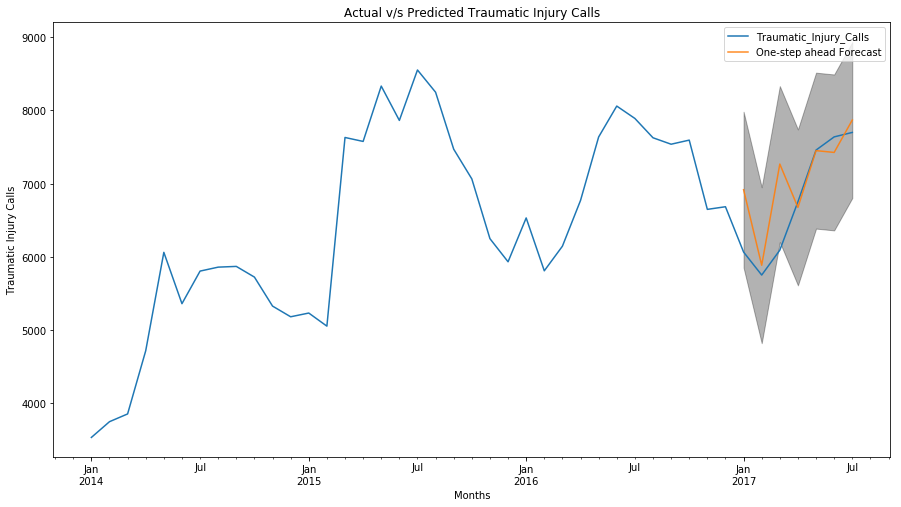

In [7]:
def forecastTRAUMA(in_data):
    mod = sm.tsa.statespace.SARIMAX(trauma_injury_calls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()

    for i in range(3):
        print(results.summary().tables[i])
        
    results.plot_diagnostics(figsize=(16,8))
    plt.show()

    pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
    pred_ci = pred.conf_int() 
    ax = in_data['2014':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(15, 8))
    print(pred_ci)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.3)
    ax.set_xlabel('Months')
    ax.set_ylabel('Traumatic Injury Calls')
    plt.legend()
    plt.title('Actual v/s Predicted Traumatic Injury Calls')
    plt.show()
    
forecastTRAUMA(trauma_injury_calls)